# A neural network for predicting the calorie content of dishes

## Load libs

In [1]:
import math
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from typing import List

from scripts.dataset import MultimodalDataset
from scripts.utils import evaluate_on_test, plot_metrics, train

/Users/satanislav/Documents/projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

### Data collection

In [2]:
cur_dir: Path = Path(__name__).parent.resolve()

data_dir_name:str = "data"
data_dir: Path = cur_dir / Path(data_dir_name)

dish_file_name: str = "dish.csv"
dish_path: str = str(data_dir / Path(dish_file_name))

ing_file_name: str = "ingredients.csv"
ing_path: str = str(data_dir / Path(ing_file_name))

images_dir_name: str = "images"
images_dir: str = str(data_dir / Path(images_dir_name))

print("Dish path         :", dish_path)
print("Ingredients path  :", ing_path)
print("Images dir path   :", images_dir)

Dish path         : /Users/satanislav/Documents/projects/nn_for_predicting_the_calorie/data/dish.csv
Ingredients path  : /Users/satanislav/Documents/projects/nn_for_predicting_the_calorie/data/ingredients.csv
Images dir path   : /Users/satanislav/Documents/projects/nn_for_predicting_the_calorie/data/images


### Funcs

In [3]:
def plot_images(data_folder_path: str, num_cols: int, data_name: str) -> None:
    root = Path(data_folder_path)

    img_dirs = sorted([d for d in root.iterdir() if d.is_dir()])

    pairs = []
    for d in img_dirs:
        imgs = sorted([p for p in d.iterdir() if p.is_file()])
        img_path = imgs[0] if imgs else None
        pairs.append((d.name, img_path))

    pairs = pairs[:num_cols * 10]
    num_rows = math.ceil(len(pairs) / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.2))
    axes = axes.ravel()

    fig.suptitle(data_name.upper(), fontsize=14, y=1.02)

    for ax in axes:
        ax.axis("off")

    for i, (dir_name, img_path) in enumerate(pairs):
        ax = axes[i]
        ax.set_title(dir_name, fontsize=9, pad=4)

        if img_path is None:
            ax.text(0.5, 0.5, "no image", ha="center", va="center", fontsize=10)
            continue

        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

In [4]:
def plot_hist(lst_with_lengths: List[int], col_name: str ="") -> None:
    plt.hist(lst_with_lengths, bins=50, edgecolor="black")
    plt.title(f"{col_name} distribution")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

### Ingridients and dishes

In [5]:
ing_data = pd.read_csv(ing_path)
dish_data = pd.read_csv(dish_path)

In [6]:
ing_data.head()

id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes

In [7]:
ing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


In [8]:
print("Ingredient dataset shape      :", ing_data.shape[0])
print("Unique ingredients in dataset :", len(ing_data.ingr.unique()))

Ingredient dataset shape      : 555
Unique ingredients in dataset : 552


Duplicates

In [9]:
duplicates = ing_data[ing_data.ingr.duplicated(keep=False)]
duplicates.head()

id        ingr
230  231  deprecated
452  453  deprecated
457  458  deprecated
469  470  deprecated

In [10]:
duplicates_idx: list[int] = duplicates.id.to_list()

Remove it

In [11]:
ing_data = ing_data[ing_data.ingr != "deprecated"]

print("Ingredient dataset shape after      :", ing_data.shape[0])
print("Unique ingredients in dataset after :", len(ing_data.ingr.unique()))

Ingredient dataset shape after      : 551
Unique ingredients in dataset after : 551


In [12]:
dish_data.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train

In [13]:
dish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.6+ KB


In [14]:
dish_data.describe()

total_calories   total_mass
count     3262.000000  3262.000000
mean       255.012738   214.980074
std        219.637570   161.497428
min          0.000000     1.000000
25%         80.114996    92.000000
50%        209.110062   177.000000
75%        375.122963   305.000000
max       3943.325195  3051.000000

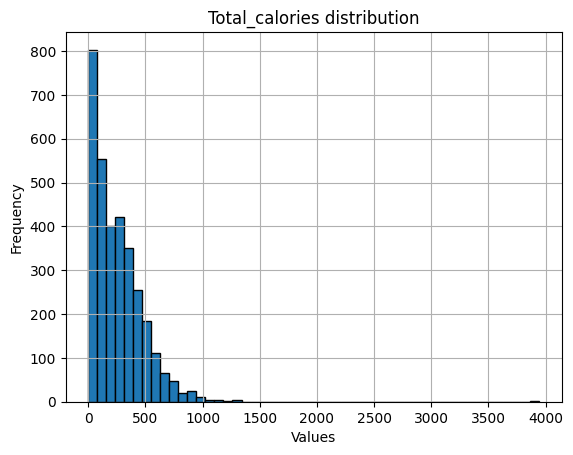

In [15]:
plot_hist(dish_data.total_calories, "Total_calories")

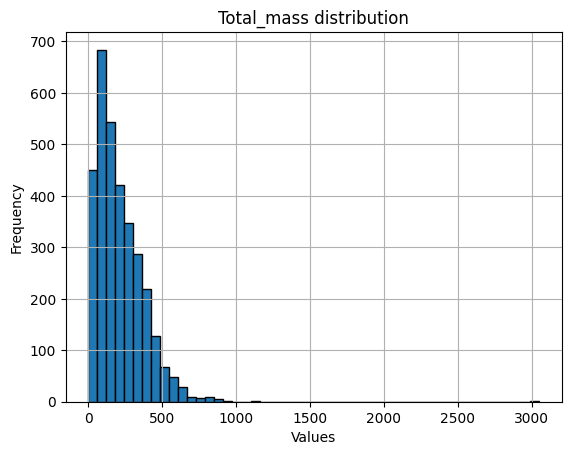

In [16]:
plot_hist(dish_data.total_mass, "Total_mass")

In [17]:
outlier = dish_data.query("total_calories > 3000")

print("Outlier")
display(outlier)

Outlier


dish_id  total_calories  total_mass  \
1518  dish_1560974769     3943.325195      3051.0   

                                            ingredients  split  
1518  ingr_0000000036;ingr_0000000251;ingr_000000004...  train

Remove outlier

In [18]:
dish_data = dish_data[dish_data.total_calories < 3000]

In [19]:
ingredient_dict = ing_data.set_index('id')['ingr'].to_dict()
RE_LEADING_ZEROS = re.compile(r'^0+(?=\d)')

def replace_ingredients(code_string: str, pattern, ingredient_dict) -> str:
    lst_ingrs_code: List[str] = [x for x in code_string.split(";")]
    numeric_code: List[str] = [code.split("_")[1] for code in lst_ingrs_code]
    formatted_code: List[str] = [pattern.sub("", code) for code in numeric_code]
    replaced_code: List[str] = [ingredient_dict.get(int(code)) for code in formatted_code if int(code) not in duplicates_idx]
    return ",".join(replaced_code)

In [20]:
dish_data["ingredients"] = dish_data["ingredients"].apply(lambda code_string: replace_ingredients(code_string,
                                                                                                  RE_LEADING_ZEROS,
                                                                                                  ingredient_dict))

Scale total mass

In [21]:
calories_scaler = StandardScaler()
mass_scaler = StandardScaler()

train_val_df = dish_data.loc[dish_data["split"] == "train"].copy()
test_df  = dish_data.loc[dish_data["split"] == "test"].copy()

train_val_df["total_calories"] = calories_scaler.fit_transform(train_val_df[["total_calories"]]).ravel()
test_df["total_calories"]  = calories_scaler.transform(test_df[["total_calories"]]).ravel()

train_val_df["total_mass"] = mass_scaler.fit_transform(train_val_df[["total_mass"]]).ravel()
test_df["total_mass"]  = mass_scaler.transform(test_df[["total_mass"]]).ravel()

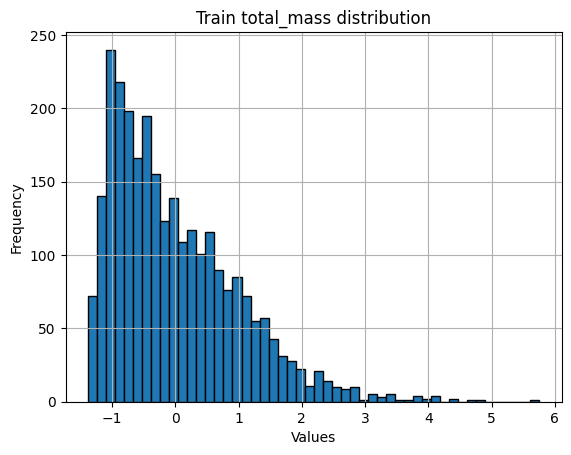

In [22]:
plot_hist(train_val_df["total_mass"], "Train total_mass")

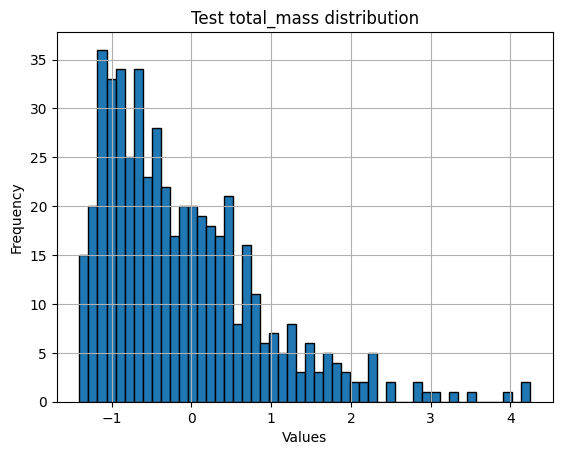

In [23]:
plot_hist(test_df["total_mass"], "Test total_mass")

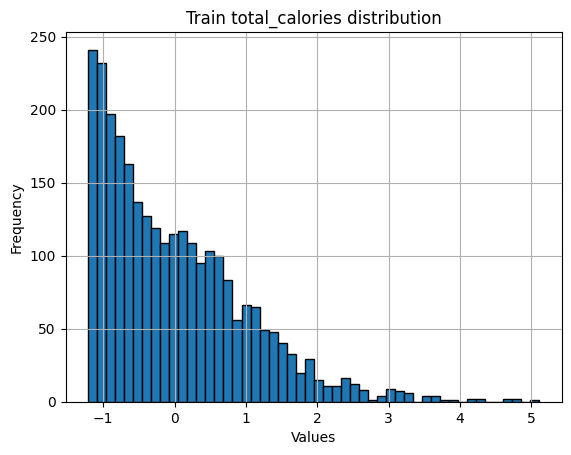

In [24]:
plot_hist(train_val_df["total_calories"], "Train total_calories")

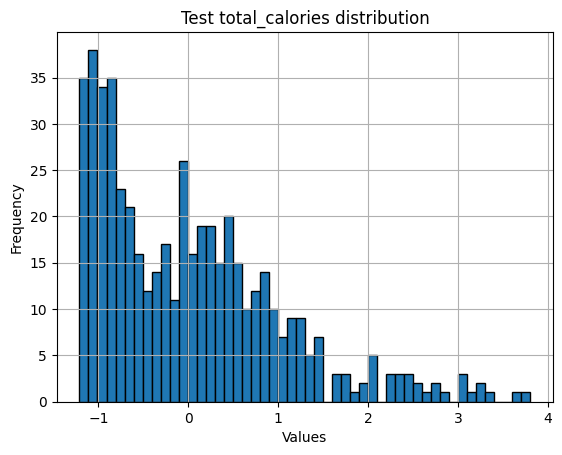

In [25]:
plot_hist(test_df["total_calories"], "Test total_calories")

In [26]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2)

In [27]:
print("TRAIN AND VAL DF SIZE:", train_val_df.shape)
print("TRAIN DF SIZE.       :", train_df.shape)
print("VAL DF SIZE          :", val_df.shape)

TRAIN AND VAL DF SIZE: (2754, 5)
TRAIN DF SIZE.       : (2203, 5)
VAL DF SIZE          : (551, 5)


In [28]:
train_df_path: str = str(data_dir / Path("train.csv"))
train_df.to_csv(train_df_path)

val_df_path: str = str(data_dir / Path("val.csv"))
val_df.to_csv(val_df_path)

test_df_path: str = str(data_dir / Path("test.csv"))
test_df.to_csv(test_df_path)

In [29]:
del duplicates, plot_hist, outlier, replace_ingredients, ingredient_dict,mass_scaler, ing_data, dish_data, train_val_df

#### Images

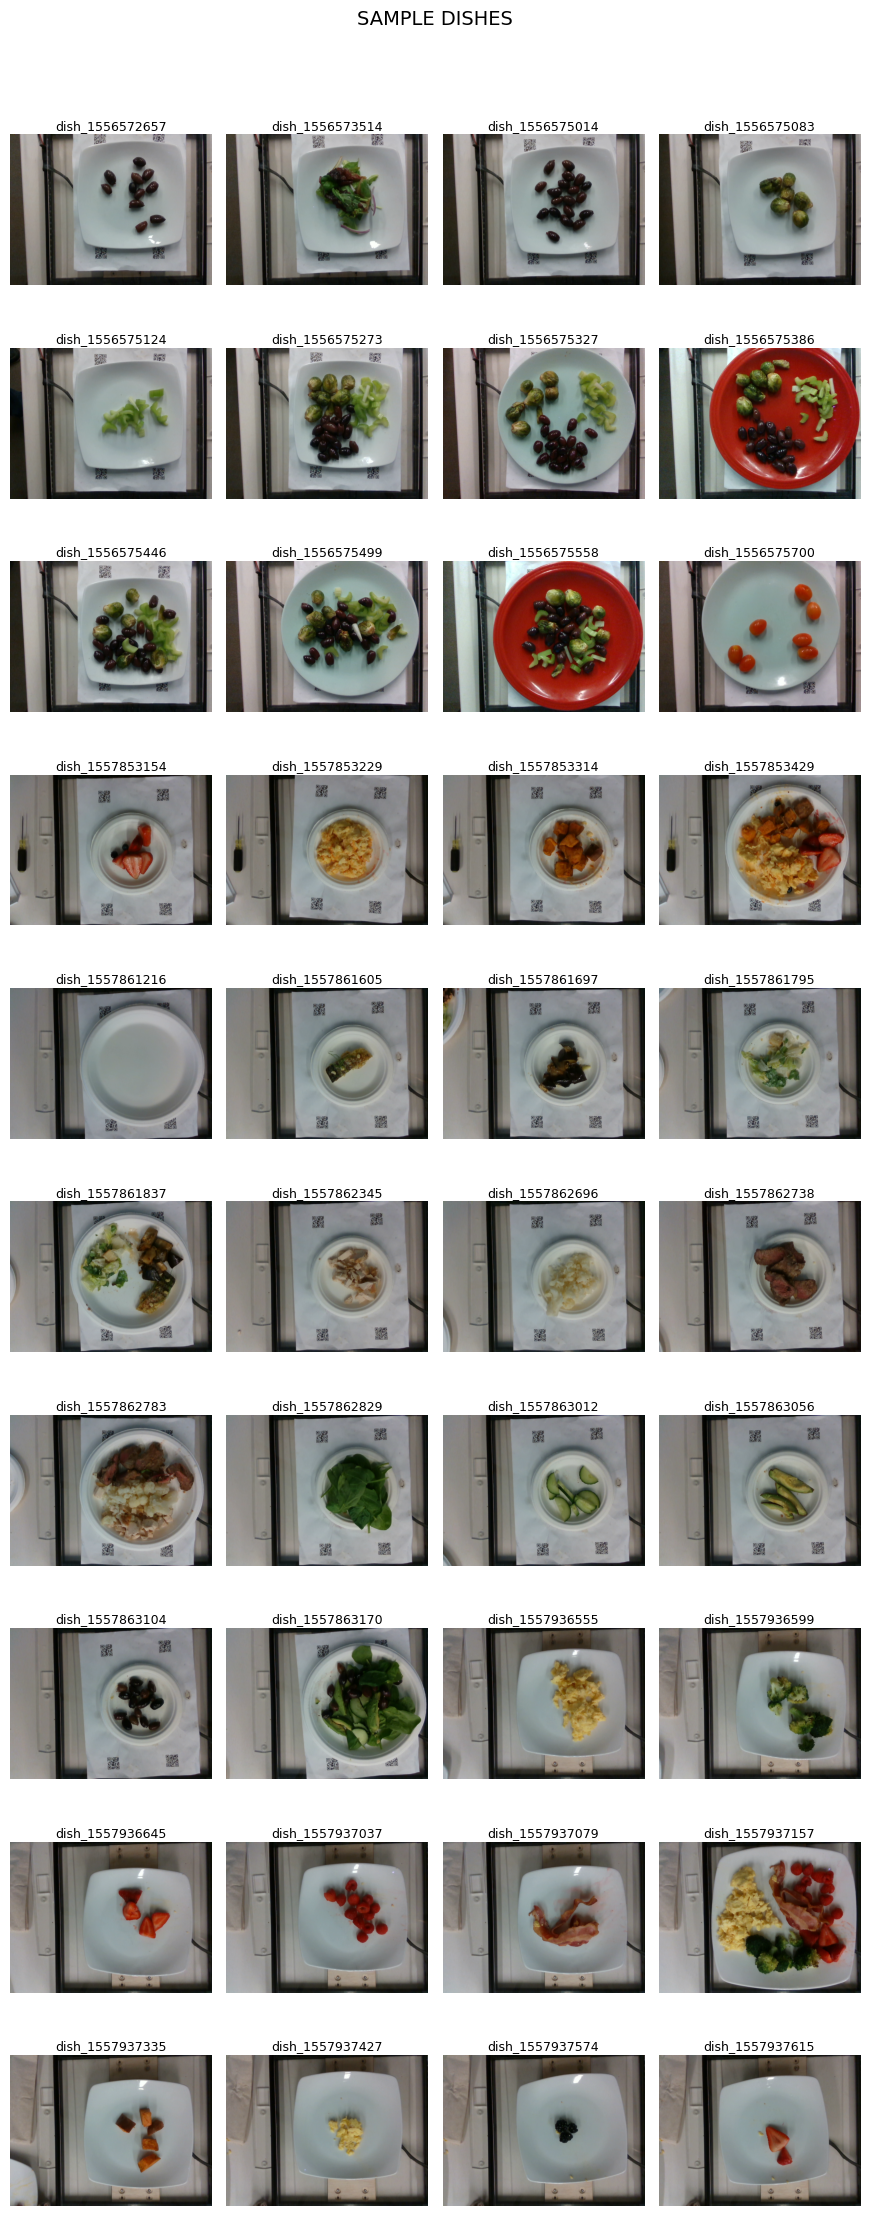

In [30]:
plot_images(images_dir, num_cols=4, data_name="SAMPLE DISHES")

In [31]:
del plot_images

### Report

- Performed exploratory data analysis (EDA) and visualized key distributions and relationships.
- Removed duplicate records and filtered out outliers to reduce noise.
- Decoded ingredient digital codes into meaningful values/features.
- Scaled features variable to stabilize optimization and improve convergence.
- Selected MAE as the primary evaluation metric.

Next steps (multimodal features)
- Build embeddings from the tabular features and from the images, then fuse them into a single model (e.g., concatenation + MLP head, or a gated/attention fusion block).
- Apply image augmentation during training (random crop/resize, flips, color jitter, mild rotation, etc.) to improve generalization and stabilize learning.

## Learning pipeline

In [32]:
class Config:
    SEED = 42

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    TRAIN_DF_PATH = "data/train.csv"
    VAL_DF_PATH = "data/val.csv"
    TEST_DF_PATH = "data/test.csv"

    BATCH_SIZE = 64

    EPOCHS = 35

    WEIGHT_DECAY = 0.01

    TEXT_LR = 2e-5
    IMAGE_LR = 2e-5
    REGRESSOR_LR = 1e-3

    LR_FACTOR = 0.5
    LR_PATIENCE = 2
    LR_THRESHOLD = 0.1
    MIN_LR = 1e-6

    HIDDEN_DIM = 256
    MASS_DIM = 32

    MODEL_SAVE_PATH = "models/best_model.pth"

In [33]:
config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model train

In [34]:
%%time
metrics_history = train(config, calories_scaler, device)

Unfreezed layer: encoder.layer.11.attention.self.query.weight
Unfreezed layer: encoder.layer.11.attention.self.query.bias
Unfreezed layer: encoder.layer.11.attention.self.key.weight
Unfreezed layer: encoder.layer.11.attention.self.key.bias
Unfreezed layer: encoder.layer.11.attention.self.value.weight
Unfreezed layer: encoder.layer.11.attention.self.value.bias
Unfreezed layer: encoder.layer.11.attention.output.dense.weight
Unfreezed layer: encoder.layer.11.attention.output.dense.bias
Unfreezed layer: encoder.layer.11.attention.output.LayerNorm.weight
Unfreezed layer: encoder.layer.11.attention.output.LayerNorm.bias
Unfreezed layer: encoder.layer.11.intermediate.dense.weight
Unfreezed layer: encoder.layer.11.intermediate.dense.bias
Unfreezed layer: encoder.layer.11.output.dense.weight
Unfreezed layer: encoder.layer.11.output.dense.bias
Unfreezed layer: encoder.layer.11.output.LayerNorm.weight
Unfreezed layer: encoder.layer.11.output.LayerNorm.bias
Unfreezed layer: pooler.dense.weight
Unf

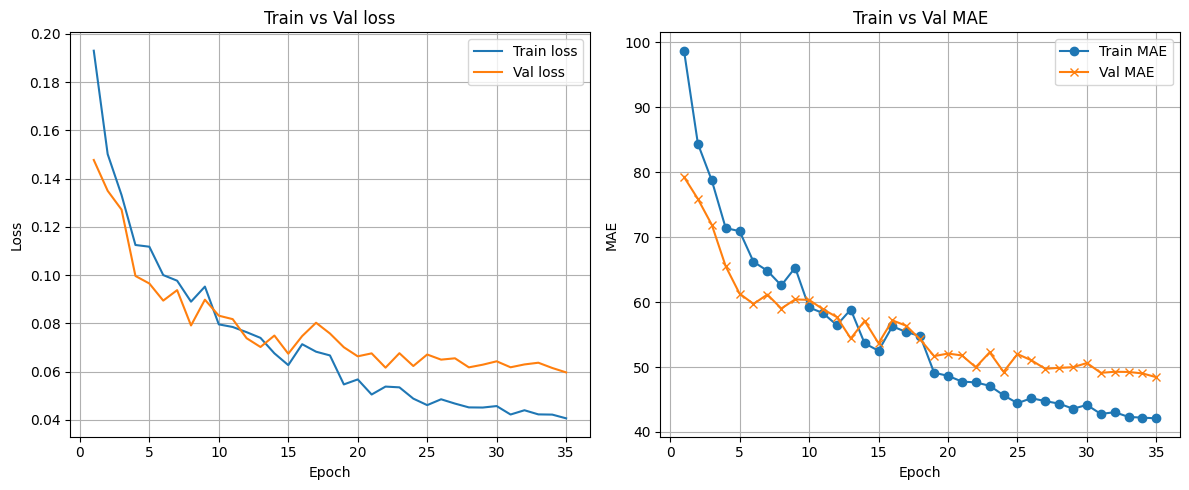

In [35]:
plot_metrics(metrics_history)

## Model validation

TEST MAE (kcal): 48.43


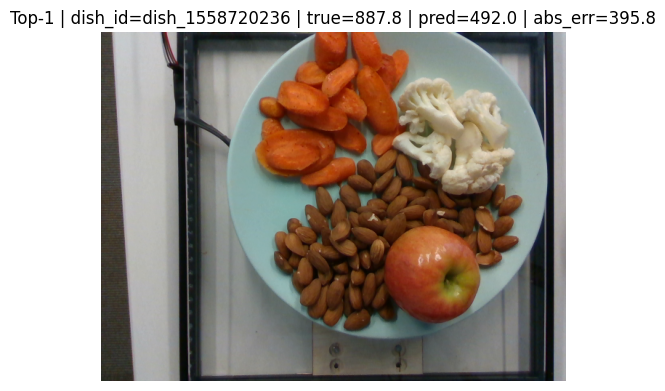

Ingredients: apple,carrot,cauliflower,almonds
------------------------------------------------------------------------------------------


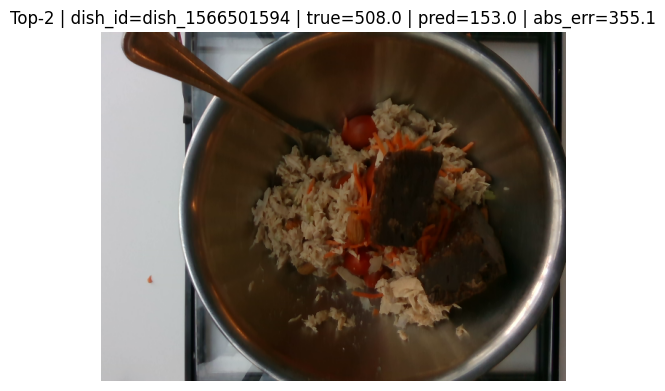

Ingredients: brownies
------------------------------------------------------------------------------------------


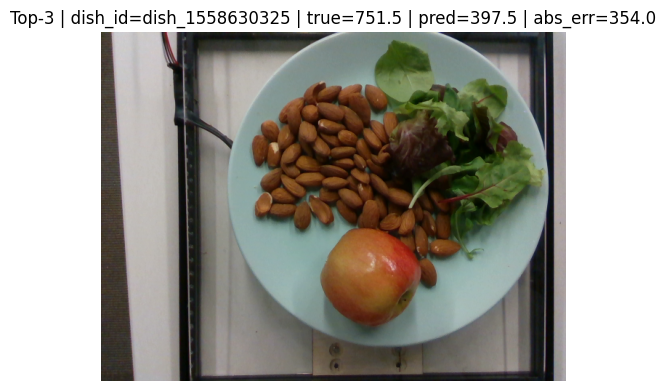

Ingredients: apple,garden salad,almonds
------------------------------------------------------------------------------------------


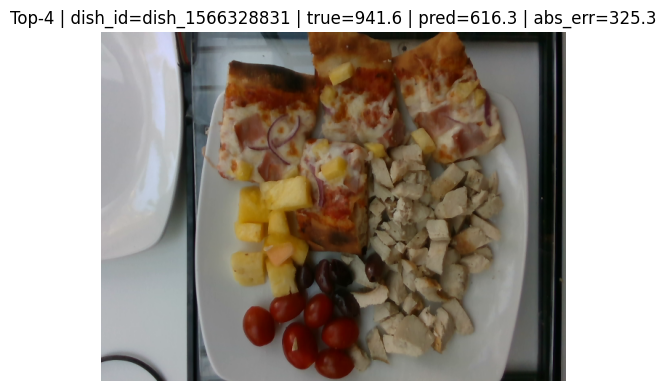

Ingredients: pizza,cherry tomatoes,chicken,pineapple,olives
------------------------------------------------------------------------------------------


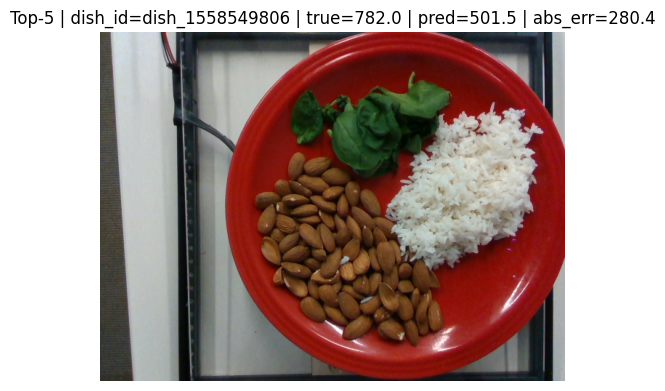

Ingredients: almonds,white rice,spinach (raw)
------------------------------------------------------------------------------------------


In [36]:
evaluate_on_test(
    config=config,
    calories_scaler=calories_scaler,
    device=device,
    top_k = 5,
    show = True,
)

## Conclusion

***Top-1 (dish_1558720236) true≈887.8, pred≈492.0 (−395.8)***

On the plate: almonds + apple + (looks like) carrot/cauliflower.

Why it could have “failed”:

- Nuts: calories “hide" in a small amount. Visually, almonds are often perceived by the model as “not much food,” but they are very high in calories.
- Mixed set: vegetables/fruits pull the prediction down (“dietary” visual association), and the model may underestimate the contribution of nuts.
- A portion of nuts is difficult to scale: the size of nuts/mound without an explicit scale → error in estimating the quantity.


***Top-2 (dish_1566501594) true≈508.0, pred≈153.0 (−355.1)***

Frame: bowl/pan, rice/cereal + vegetables, partially mixed, there are objects/ tools.

Why:
- Poor “visibility” of food: most of the mass is hidden/mixed/against a metal background → the image features are less informative.
- The “cooking" rather than “serving” scene: the model was probably trained in more “plate-like” presentations; the pan may trigger incorrect visual patterns.
- Rice/cereals: the caloric content increases sharply from a serving, but it is difficult to estimate a portion from a photo in a deep container → the model “plays safe" and underestimates.


***Top-3 (dish_1558630325) true≈751.5, pred≈397.5 (−354.0)***

On the plate: a lot of almonds + an apple + lettuce leaves.

Why:
- Again, nuts as the main source of calories → a typical case of underestimation of caloric density.
- Salad is visually dominant (bright green, associated with low calories) → can “drag” the prediction down.
- If “almonds” is found less frequently in the ingredients text/in a smaller variety of portions, the model may not have learned the scale.

***Top-4 (dish_1566328831) true≈941.6, pred≈616.3 (−325.3)***

On the plate: pizza/baking slices + chicken pieces + tomatoes + fruits.

Why:
- Strong compositional complexity: many components, different products, some layered → it is difficult to estimate the total caloric content.
- “Hidden calories": pizza/sauces/cheese/butter provide a lot of energy, but the model may not visually distinguish the degree of fat content/cheese/dough thickness.
- If there are no explicit markers in the ingredients text (“pizza”, “cheese”, “oil”), then the model may underestimate baking.

***Top-5 (dish_1558549806) true≈782.0, pred≈501.5 (−280.4)***

On a plate: almonds + rice + herbs.

Why:
- Two “dangerous” sources: nuts + rice. Both require a good portion estimate.
- Pic: it is difficult to visually understand “how many grams”, especially without a scale.
- Greens can again give a “low calorie signal”, reducing the total.